In [1]:
%matplotlib inline

In [2]:
import pathlib

In [3]:
import joblib
import lightgbm as lgb
import pandas as pd

In [4]:
categorical_cols = ["store_id", "item_id"]

In [5]:
root_dir_path = pathlib.Path("..")
data_dir_path = root_dir_path / "data"
processed_dir_path = data_dir_path / "processed"
train_path = processed_dir_path / "train_filtered.parquet"
models_dir_path = root_dir_path / "models"
model_path = models_dir_path / "model.joblib"

In [6]:
train = pd.read_parquet(train_path)

In [7]:
train.shape

(45942500, 15)

In [8]:
train[categorical_cols] = train[categorical_cols].astype("category")

In [9]:
is_train = train["date"] <= "2016-01-28"
train, valid = train[is_train], train[~is_train]

In [10]:
train.shape

(43290018, 15)

In [11]:
valid.shape

(2652482, 15)

In [12]:
data = train.select_dtypes(["category", "number"])
data_valid = valid.select_dtypes(["category", "number"])

In [13]:
data.describe(include="all")

,item_id,store_id,demand,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
count,43290018,43290018,4.329002e+07,4.329002e+07,4.329002e+07,4.329002e+07,4.329002e+07,4.329002e+07
unique,3049,10,NaN,NaN,NaN,NaN,NaN,NaN
top,HOUSEHOLD_2_299,TX_2,NaN,NaN,NaN,NaN,NaN,NaN
freq,18260,4449544,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.432720e+00,1.135948e+04,3.273593e-01,3.278231e-01,3.278760e-01,4.403153e+00
std,NaN,NaN,4.351036e+00,1.356624e+02,4.692496e-01,4.694200e-01,4.694394e-01,3.394033e+00
min,NaN,NaN,0.000000e+00,1.110100e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02
25%,NaN,NaN,0.000000e+00,1.123900e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.180000e+00
50%,NaN,NaN,0.000000e+00,1.135200e+04,0.000000e+00,0.000000e+00,0.000000e+00,3.470000e+00
75%,NaN,NaN,1.000000e+00,1.150100e+04,1.000000e+00,1.000000e+00,1.000000e+00,5.840000e+00


In [14]:
X = data
X_valid = data_valid
y = data.pop("demand")
y_valid = data_valid.pop("demand")

In [15]:
model = lgb.LGBMRegressor(importance_type="gain", random_state=0)

In [16]:
model.fit(X, y, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)])

[1]	valid_0's l2: 12.2283
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 11.2857
[3]	valid_0's l2: 10.5508
[4]	valid_0's l2: 9.96147
[5]	valid_0's l2: 9.47285
[6]	valid_0's l2: 9.08711
[7]	valid_0's l2: 8.7715
[8]	valid_0's l2: 8.52578
[9]	valid_0's l2: 8.289
[10]	valid_0's l2: 8.11473
[11]	valid_0's l2: 7.99389
[12]	valid_0's l2: 7.86397
[13]	valid_0's l2: 7.77128
[14]	valid_0's l2: 7.69648
[15]	valid_0's l2: 7.60697
[16]	valid_0's l2: 7.53724
[17]	valid_0's l2: 7.49034
[18]	valid_0's l2: 7.4358
[19]	valid_0's l2: 7.37776
[20]	valid_0's l2: 7.30106
[21]	valid_0's l2: 7.27589
[22]	valid_0's l2: 7.23148
[23]	valid_0's l2: 7.19192
[24]	valid_0's l2: 7.16547
[25]	valid_0's l2: 7.13721
[26]	valid_0's l2: 7.10733
[27]	valid_0's l2: 7.09689
[28]	valid_0's l2: 7.07507
[29]	valid_0's l2: 7.05623
[30]	valid_0's l2: 7.0411
[31]	valid_0's l2: 7.0156
[32]	valid_0's l2: 6.99458
[33]	valid_0's l2: 6.97434
[34]	valid_0's l2: 6.96105
[35]	valid_0's l2: 6.95356
[36]	vali

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='gain', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

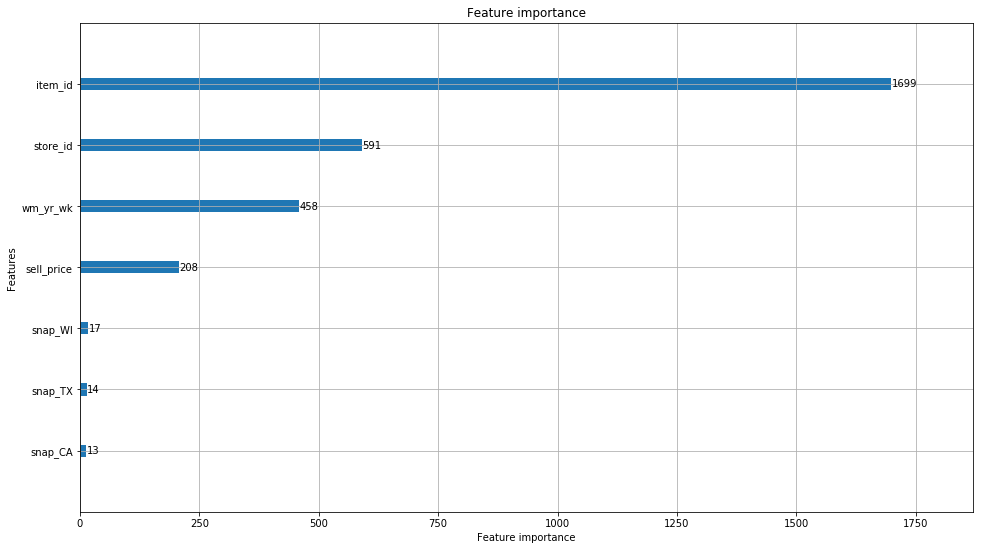

In [17]:
ax = lgb.plot_importance(model, figsize=(16, 9))

In [18]:
joblib.dump(model, model_path)

['..\\models\\model.joblib']